# **Atividade Computacional 02 - TEEC III**
## **Aluno: André Paiva Conrado Rodrigues**

## Importando bibliotecas

Nesta seção do código, são importadas bibliotecas de manipulação de dados importantes para a obtenção das amostras dos arquivos de áudio, bem como para a manipulação das mesmas.

São utilizadas as bibiliotecas `scipy` para cálculo dos dados do espectrograma e para cálculo da FFT e `matplotlib` para plotagem de gráficos e do espectrograma.


In [17]:
import numpy as np
import math
from scipy import signal, fft
from scipy.io import wavfile
import matplotlib.pyplot as plt

## Função para separação de arquivos stereo

Para tornar as funções compatíveis com arquivos de áudio stereo, desenvolvi essa função para separar o np.array resultante da leitura do arquivo em dois np.arrays, um para cada canal.

Esta função é utilizada tanto para a plotagem de espectrogramas quanto para as funções de detecção de onsets.

In [18]:
def separa_stereo(data_np_array):
    cont = 0
    tmpListDataL = []
    tmpListDataR = []
    while cont < data_np_array.shape[0]:
        tmpListDataL.append(data_np_array[cont][0])
        tmpListDataR.append(data_np_array[cont][1])
        cont = cont + 1
    dataL = np.array(tmpListDataL)
    dataR = np.array(tmpListDataR) 
    return dataL, dataR

## Espectrograma

**ESCREVER ALGO AQUI**

## Traçando espectrogramas

No trecho de código abaixo, é definida a função `spectro`, que tem por função geral:
* Importar o arquivo `.wav`;
* Ler tamanho de janela definida pelo usuário (é utilizada a janela Hann);
* Definir se o arquivo é mono ou stereo e separar os canais caso seja stereo;
* Plotar o espectrograma (caso o arquivo seja stereo, é plotado um espectrograma para cada canal).

Para a plotagem do espectrograma propriamente dita, foi definida a função `spectroPlot`, que utiliza diretamente comandos da biblioteca `matplotlib`. Esta função é chamada dentro da função `spectro`.

In [19]:
def spectroPlot(audioArray, rate, windowSize, vmin, vmax, title):
    f, t, Sxx = signal.spectrogram(audioArray, rate, nperseg=windowSize)
    plt.figure(figsize=(20,5))
    plt.pcolormesh(t, f, np.abs(Sxx), shading='flat', cmap='PRGn', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel('Frequência [Hz]')
    plt.xlabel('Tempo [s]')
    plt.colorbar()
    plt.show()
    
def spectro(file, windowSize):
    filename = file
    vmin = 0
    vmax = 1023
    samplerate, data = wavfile.read(filename)
    qtdSamples = data.shape[0]
    if(data.ndim == 2):
        dataL, dataR = separa_stereo(data)  
    if(data.ndim == 2):
        spectroPlot(dataL, samplerate, windowSize, vmin, vmax, 'Espectrograma do Canal L')
        spectroPlot(dataR, samplerate, windowSize, vmin, vmax, 'Espectrograma do Canal R')
        del dataL, dataR
    else:
        spectroPlot(data, samplerate, windowSize, vmin, vmax, 'Espectrograma do Sinal')
        del data

## Plotagem de espectrograma de arquivo mono

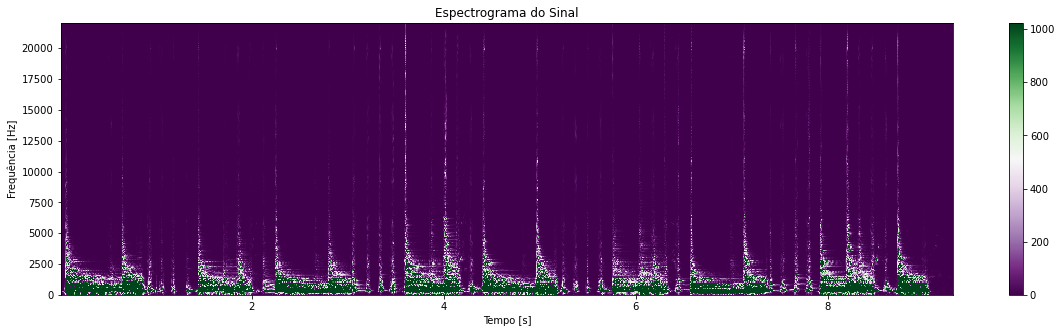

In [20]:
file = 'guitar.wav'
spectro(file, 512)

## Plotagem de espectrogramas de arquivo stereo

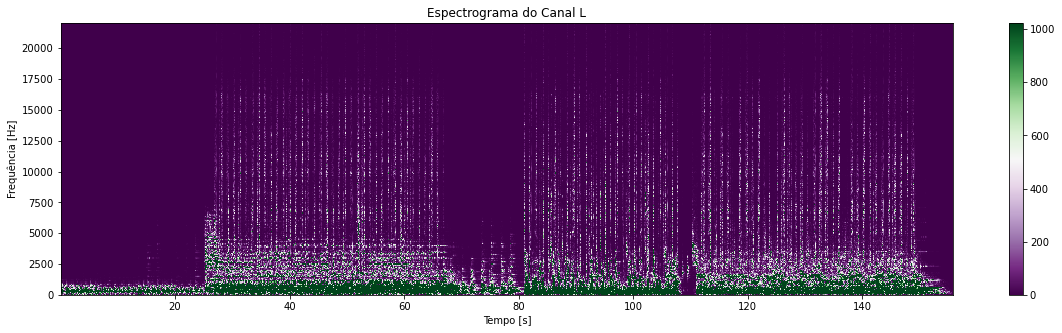

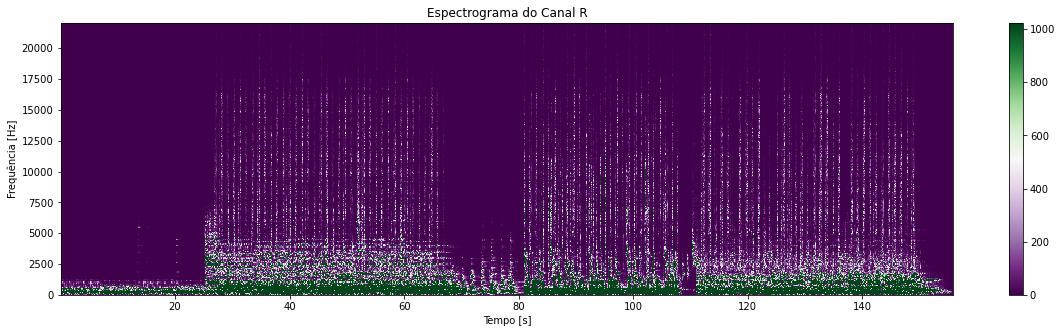

In [21]:
file = 'cover_altj_intro.wav'
spectro(file, 512)

## Função de detecção de onsets (ODF)

> Uma função de detecção de onsets é uma função com o objetivo de representar claramente os instantes de um arquivo de áudio onde há uma grande variação de intensidade, indicando que nesses instantes há o início de algum evento específico no áudio, como por exemplo uma batida no bumbo da bateria ou um acorde tocado em um violão.

Abaixo, é definida uma função `ODF`, capaz de utilizar tanto o método do conteúdo de alta frequência (HFC) quanto o método da diferença espectral (SD). Foram definidas três funções auxiliares que são utilizadas na função `ODF`.

A seguir será dada uma breve explicação sobre cada uma das funções e o embasamento matemático das mesmas.

### Cálculos pelo método da diferença espectral (HFC)

Abaixo está a função auxiliar `ODF_HFC_CALC`, responsável pelos cálculos de ODF referentes ao método da diferença espectral.

Neste método, estamos aplicando janelas Hann ao longo do sinal `data_np_array` com uma quantidade de amostras `windowSize` e `overlap` definido pelo usuário, e aplicando o método da diferença espectral para detecção de onsets.

Matematicamente, utilizo a fórmula abaixo para calcular o valor da ODF para cada janela:

$$ODF_{HFC}(i) = \frac{2}{w}\sum_{k=1}^{w/2}|k| \cdot |X(i+k)|^2$$

Sendo:
* $i$ o índice da amostra inicial da janela aplicada no sinal;
* $w$ o tamanho da janela (no código, `windowSize`);
* $X$ a FFT do sinal de áudio janelado (no código, `ffttmp`).

A cada valor de $ODF_{HFC}$ calculado, o índice `i` é incrementado em `windowSize * (1 - overlap)`, e o valor calculado é inserido na lista `hfc_calc`, inicialmente vazia. Após todos os valores serem calculados, tal lista é retornada no final da função.

O numpy array `sizerange` foi criado para possibilitar a ponderação de cada amostra com seu respectivo índice, assim como indicado no somatório da fórmula matemática.


In [22]:
def ODF_HFC_CALC(data_np_array, windowSize, overlap):
    sizerange = np.arange(1, windowSize+1)
    hfc_calc = []
    i = 0
    while i < data_np_array.shape[0]:
        datatmp = data_np_array[i : i + windowSize]
        ffttmp = fft.fft(datatmp, n=windowSize)
        ffttmp = abs(sizerange)*(abs(ffttmp)**2)
        hfc_calc.append(np.sum(abs(ffttmp[0:int(windowSize/2)]))*(2/windowSize))
        i = i + int(windowSize*(1-overlap))
    return hfc_calc

In [23]:
def ODF_SD_CALC(data_np_array, windowSize, overlap):
    sd_calc = []
    i = 0
    while i < data_np_array.shape[0]:
        indexOverlapStart = int(i + (windowSize*(1-overlap)))
        indexOverlapEnd = int(indexOverlapStart + windowSize)
        datatmp1 = data_np_array[i : i+windowSize]
        ffttmp1 = fft.fft(datatmp1, n=windowSize)
        datatmp2 = data_np_array[indexOverlapStart : indexOverlapEnd]
        ffttmp2 = fft.fft(datatmp2, n=windowSize)
        diftmp = abs(ffttmp1) - abs(ffttmp2)
        diftmp = ((diftmp + abs(diftmp))/2)**2
        sd_calc.append(np.sum(abs(diftmp[0:int(windowSize/2)])))
        i = i + int(windowSize*(1-overlap))
    return sd_calc

In [24]:
def ODF_PLOT(x_axis, y_axis, tipo, canal="MONO"):
    plt.figure(figsize=(15,5))
    plt.margins(0, 0)
    graphcolor = 'g'
    title = "ODF - "
    if tipo == "HFC":
        title = title + "Método do conteúdo de alta frequência"
        plt.ylabel('Diferença energética')
    elif tipo == "SD":
        title = title + "Método da diferença espectral"
        plt.ylabel('Diferença espectral')
        graphcolor = 'y'
    if canal == "L":
        title = title + " - Canal Esquerdo"
    elif canal == "R":
        title = title + " - Canal Direito"    
    plt.xlabel('Tempo [s]')
    plt.title(title)
    plt.plot(y_axis, x_axis, graphcolor)
    plt.show()

In [25]:
def ODF(filename, windowSize, overlap, tipo):
    samplerate, data = wavfile.read(filename)
    f = samplerate/2
    qtdSamples = data.shape[0]
    window = signal.windows.hann(windowSize)
    maxTimeAxis = qtdSamples/samplerate
    stepTimeAxis = (windowSize*(1-overlap))/samplerate
    timeAxis = np.arange(0.0, maxTimeAxis, stepTimeAxis)
    if(data.ndim == 2):
        dataL, dataR = separa_stereo(data)
        if tipo == 'HFC':
            hfcL = ODF_HFC_CALC(dataL, windowSize, overlap)
            ODF_PLOT(hfcL, timeAxis, 'HFC', 'L')
            hfcR = ODF_HFC_CALC(dataR, windowSize, overlap)
            ODF_PLOT(hfcR, timeAxis, 'HFC', 'R')
        elif tipo == 'SD':
            sdL = ODF_SD_CALC(dataL, windowSize, overlap)
            ODF_PLOT(sdL, timeAxis, 'SD', 'L')
            sdR = ODF_SD_CALC(dataR, windowSize, overlap)
            ODF_PLOT(sdR, timeAxis, 'SD', 'R')
        del dataL, dataR
    else:
        if tipo == 'HFC':
            hfc = ODF_HFC_CALC(data, windowSize, overlap)
            ODF_PLOT(hfc, timeAxis, 'HFC') 
        elif tipo == 'SD':
            sd = ODF_SD_CALC(data, windowSize, overlap)
            ODF_PLOT(sd, timeAxis, 'SD') 
        del data

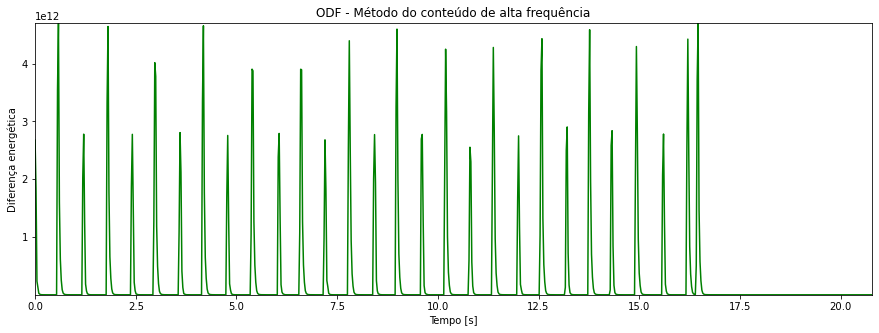

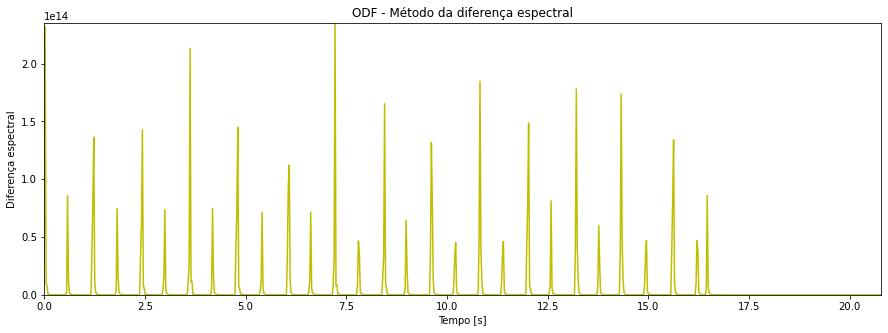

In [26]:
file = 'bat_jean_100bpm.wav'
ODF(file, 2048, 0.5, 'HFC')
ODF(file, 2048, 0.5, 'SD')

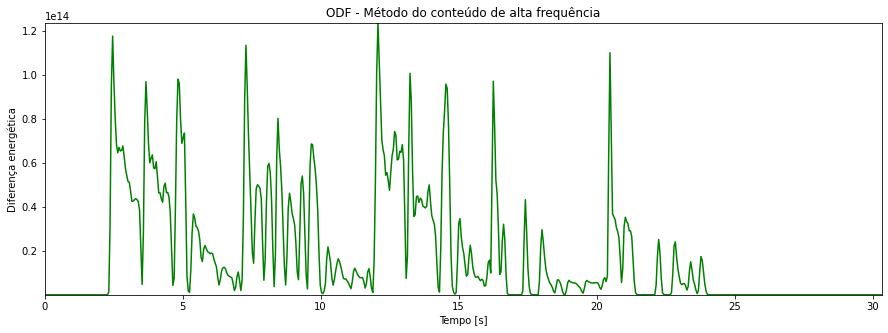

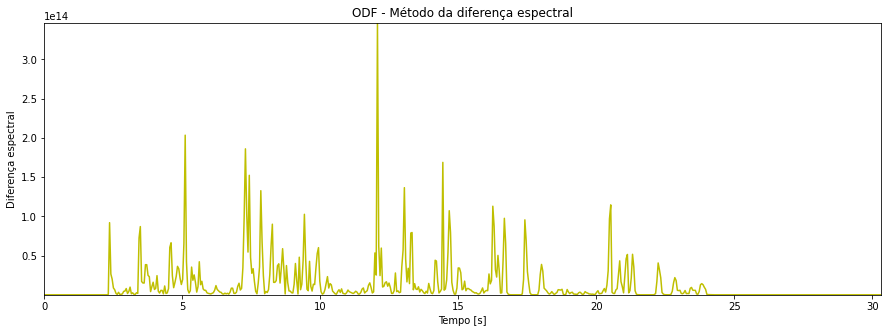

In [27]:
file = 'GaitaTese.wav'
ODF(file, 4096, 0.5, 'HFC')
ODF(file, 4096, 0.5, 'SD')

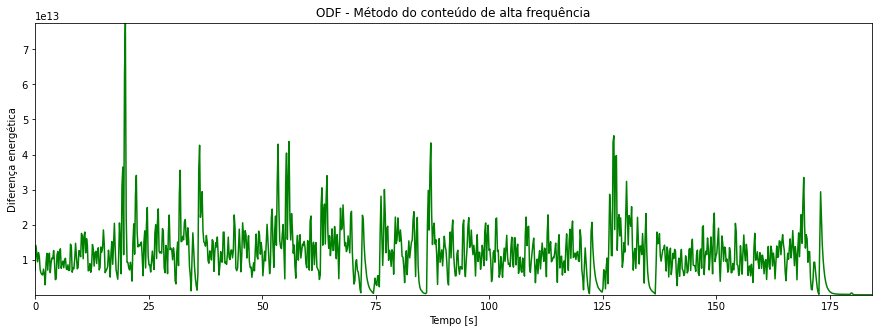

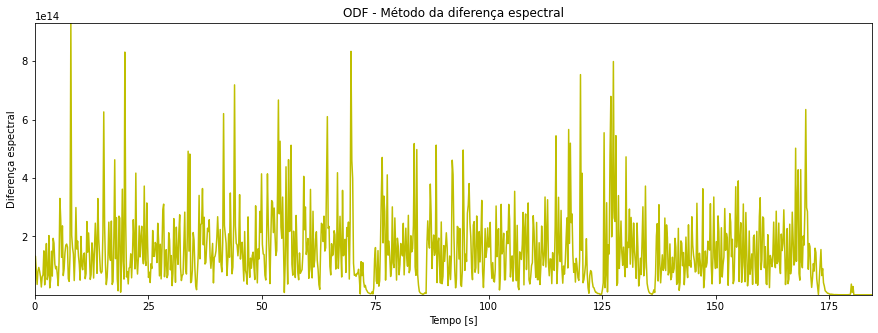

In [28]:
file = 'Only Sleeping100bpm(Violao).wav'
ODF(file, 16384, 0.5, 'HFC')
ODF(file, 16384, 0.5, 'SD')